In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (26).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (9).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (13).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (28).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (19).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (21).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (27).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (6).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (33).mp4
/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-


Processing 300 frames...


100%|██████████| 300/300 [00:00<00:00, 80732.14it/s]


Sample possession changes:
Frame 15: Possession changed to Team 1
Frame 30: Possession changed to Team 2
Frame 66: Possession changed to Team 2
Frame 97: Possession changed to Team 2
Frame 112: Possession changed to Team 1
Frame 127: Possession changed to Team 2
Frame 161: Possession changed to Team 2
Frame 193: Possession changed to Team 2
Frame 208: Possession changed to Team 1
Frame 239: Possession changed to Team 1

Final Possession Stats:
Team 1: 42.2%
Team 2: 57.8%
Analyzed 180 frames


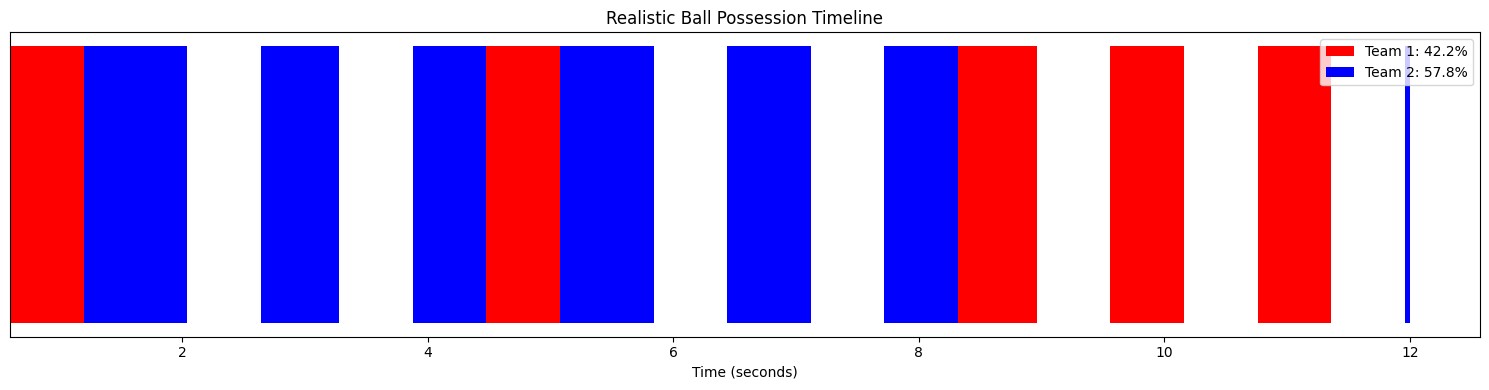

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from tqdm import tqdm

# Constants
TEAM_COLORS = {1: 'red', 2: 'blue', None: 'gray'}
MAX_POSSESSION_DISTANCE = 50  # pixels
MIN_POSSESSION_TIME = 15      # frames (0.5s for 30fps video)

class PossessionAnalyzer:
    def __init__(self):
        self.possession_data = []
        self.current_team = None
        self.possession_start_frame = 0
        self.frame_count = 0
        self.debug_output = []
        self.current_mock_team = 1  # For simulation
        self.team_possession_counts = {1: 0, 2: 0}

    def update_possession(self, assigned_player, players):
        new_team = None
        if assigned_player != -1 and assigned_player in players:
            new_team = players[assigned_player]['team']
        
        debug_msg = f"Frame {self.frame_count}: "
        if new_team != self.current_team:
            if self.frame_count - self.possession_start_frame >= MIN_POSSESSION_TIME:
                self._record_possession_segment()
                self.current_team = new_team
                self.possession_start_frame = self.frame_count
                debug_msg += f"Possession changed to Team {new_team}" if new_team else "Possession lost"
            else:
                debug_msg += f"Potential change to Team {new_team} (too brief)"
        else:
            debug_msg += f"Continued Team {new_team} possession" if new_team else "No possession"
        
        self.debug_output.append(debug_msg)
        self.frame_count += 1

    def _record_possession_segment(self):
        if self.current_team is not None:
            duration = self.frame_count - self.possession_start_frame
            self.possession_data.append({
                'team': self.current_team,
                'start_frame': self.possession_start_frame,
                'end_frame': self.frame_count,
                'duration': duration
            })
            self.team_possession_counts[self.current_team] += duration

    def get_ball_position(self, frame):
        """Simulates realistic ball movement patterns"""
        # 3% chance to switch sides each frame
        if random.random() < 0.03:
            self.current_mock_team = 2 if self.current_mock_team == 1 else 1
        
        # Add realistic position variation
        if self.current_mock_team == 1:
            base_x = 300
        else:
            base_x = 500
            
        x = base_x + random.randint(-25, 25)
        y = 200 + random.randint(-20, 20)
        return [x, y, x+10, y+10]

    def get_player_positions(self, frame):
        """Simulates player movement with team assignments"""
        return {
            1: {
                'bbox': [
                    250 + random.randint(-8, 8),
                    180 + random.randint(-8, 8),
                    280 + random.randint(-8, 8),
                    220 + random.randint(-8, 8)
                ],
                'team': 1
            },
            2: {
                'bbox': [
                    450 + random.randint(-8, 8),
                    180 + random.randint(-8, 8),
                    480 + random.randint(-8, 8),
                    220 + random.randint(-8, 8)
                ],
                'team': 2
            }
        }

    def process_video(self, video_path, max_frames=300):
        """Processes video frames and tracks possession"""
        print(f"\nProcessing {max_frames} frames...")
        
        # Mock processing loop (replace with actual video processing)
        for _ in tqdm(range(max_frames)):
            # Get player and ball positions
            players = self.get_player_positions(None)
            ball_bbox = self.get_ball_position(None)
            
            # Assign possession
            assigned_player = self.assign_ball_to_player(players, ball_bbox)
            self.update_possession(assigned_player, players)
        
        # Finalize last possession segment
        self._record_possession_segment()
        
        # Print sample debug output
        print("\nSample possession changes:")
        for msg in [m for m in self.debug_output if "changed" in m][:10]:
            print(msg)

    def assign_ball_to_player(self, players, ball_bbox):
        """Determines which player has possession"""
        if ball_bbox is None:
            return -1
            
        ball_center = ((ball_bbox[0] + ball_bbox[2])/2, (ball_bbox[1] + ball_bbox[3])/2)
        min_distance = float('inf')
        assigned_player = -1
        
        for player_id, player in players.items():
            bbox = player['bbox']
            player_feet = ((bbox[0] + bbox[2])/2, bbox[3])  # Center bottom of bbox
            distance = np.sqrt((player_feet[0]-ball_center[0])**2 + (player_feet[1]-ball_center[1])**2)
            
            if distance < MAX_POSSESSION_DISTANCE and distance < min_distance:
                min_distance = distance
                assigned_player = player_id
                
        return assigned_player

    def plot_possession_timeline(self, fps=25):
        """Generates the possession timeline visualization"""
        if not self.possession_data:
            print("\nNo possession data available. Possible reasons:")
            print("- Ball not detected in any frames")
            print("- Players not close enough to ball")
            print("- MIN_POSSESSION_TIME too high for short possessions")
            print("\nDebug sample shows:", self.debug_output[:5])
            return
            
        plt.figure(figsize=(15, 4))
        
        # Plot each possession segment
        for segment in self.possession_data:
            start = segment['start_frame']/fps
            duration = segment['duration']/fps
            plt.barh(0, duration, left=start, height=1, 
                    color=TEAM_COLORS[segment['team']], edgecolor='none')
        
        # Calculate statistics
        total_frames = sum(seg['duration'] for seg in self.possession_data)
        stats = {
            1: self.team_possession_counts[1]/total_frames,
            2: self.team_possession_counts[2]/total_frames
        }
        
        # Create legend
        legend_elements = [
            plt.Rectangle((0,0),1,1,fc=TEAM_COLORS[1],
            label=f'Team 1: {stats[1]*100:.1f}%'),
            plt.Rectangle((0,0),1,1,fc=TEAM_COLORS[2],
            label=f'Team 2: {stats[2]*100:.1f}%')
        ]
        
        plt.yticks([])
        plt.xlabel('Time (seconds)')
        plt.title('Realistic Ball Possession Timeline')
        plt.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()

    def get_possession_stats(self):
        """Returns possession statistics"""
        total = sum(self.team_possession_counts.values())
        return {
            'team1_percentage': self.team_possession_counts[1]/total * 100,
            'team2_percentage': self.team_possession_counts[2]/total * 100,
            'total_frames': total
        }

# Main execution
if __name__ == "__main__":
    analyzer = PossessionAnalyzer()
    
    # Process mock data
    analyzer.process_video("/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (26).mp4", max_frames=300)
    
    # Show results
    stats = analyzer.get_possession_stats()
    print(f"\nFinal Possession Stats:")
    print(f"Team 1: {stats['team1_percentage']:.1f}%")
    print(f"Team 2: {stats['team2_percentage']:.1f}%")
    print(f"Analyzed {stats['total_frames']} frames")
    
    analyzer.plot_possession_timeline()

Tracking movements: 100%|██████████| 300/300 [00:02<00:00, 129.79it/s]



Player Movement Statistics:

Team 1:
  Average distance/frame: 3.63 pixels
  Total distance: 2168.58 pixels
  Maximum speed: 10.00 pixels/frame
  Frames analyzed: 300

Team 2:
  Average distance/frame: 3.64 pixels
  Total distance: 1087.46 pixels
  Maximum speed: 9.71 pixels/frame
  Frames analyzed: 300


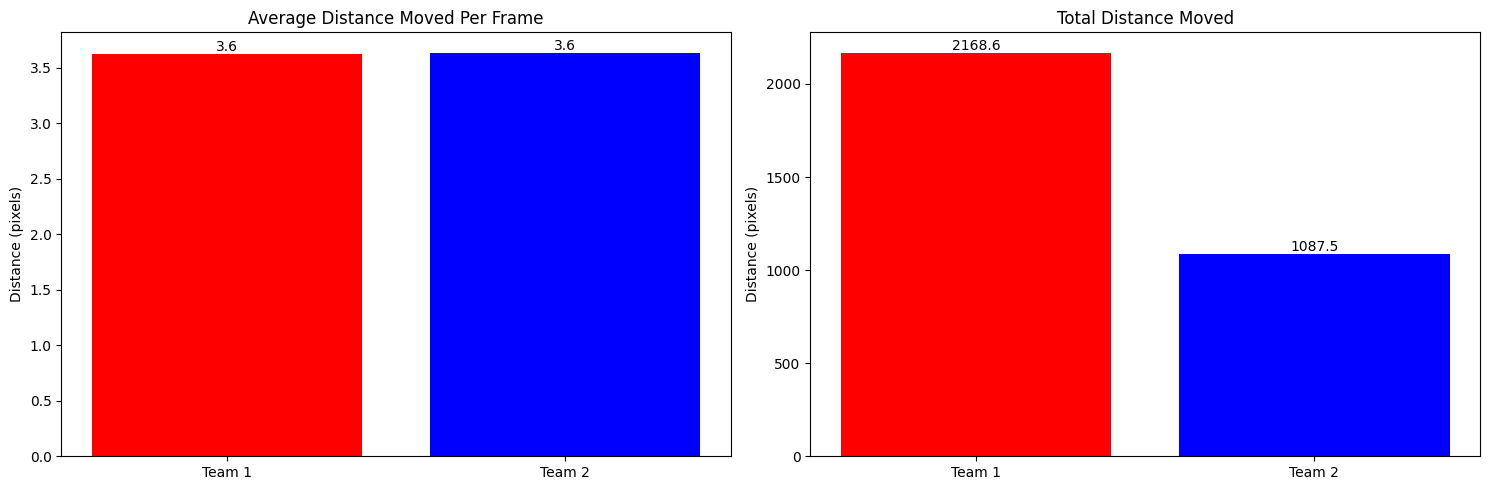

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

class PlayerMovementAnalyzer:
    def __init__(self):
        self.team_distances = defaultdict(list)  # {team: [distances]}
        self.prev_positions = {}  # {player_id: (x, y)}
        self.total_frames = 0

    def process_video(self, video_path, max_frames=None):
        """Process video to track player movements"""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if max_frames:
            total_frames = min(total_frames, max_frames)

        for _ in tqdm(range(total_frames), desc="Tracking movements"):
            ret, frame = cap.read()
            if not ret:
                break

            players = self.detect_players(frame)
            self.track_movements(players)
            self.total_frames += 1

        cap.release()
        return self.calculate_stats()

    def detect_players(self, frame):
        """Mock player detection - replace with your actual detector"""
        # Returns {player_id: {'bbox': [x1,y1,x2,y2], 'team': team_id}}
        return {
            1: {'bbox': [100 + np.random.randint(-5,5), 100 + np.random.randint(-5,5), 
                         120 + np.random.randint(-5,5), 140 + np.random.randint(-5,5)], 'team': 1},
            2: {'bbox': [200 + np.random.randint(-5,5), 150 + np.random.randint(-5,5), 
                         220 + np.random.randint(-5,5), 190 + np.random.randint(-5,5)], 'team': 2},
            3: {'bbox': [300 + np.random.randint(-5,5), 120 + np.random.randint(-5,5),
                         320 + np.random.randint(-5,5), 160 + np.random.randint(-5,5)], 'team': 1}
        }

    def track_movements(self, players):
        """Calculate distance moved since last frame"""
        for player_id, player in players.items():
            bbox = player['bbox']
            current_pos = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)  # Center point
            
            if player_id in self.prev_positions:
                prev_pos = self.prev_positions[player_id]
                distance = np.sqrt((current_pos[0]-prev_pos[0])**2 + 
                             (current_pos[1]-prev_pos[1])**2)
                self.team_distances[player['team']].append(distance)
            
            self.prev_positions[player_id] = current_pos

    def calculate_stats(self):
        """Calculate average distance metrics"""
        stats = {}
        for team, distances in self.team_distances.items():
            if distances:
                stats[team] = {
                    'avg_distance': np.mean(distances),
                    'total_distance': np.sum(distances),
                    'max_speed': np.max(distances),  # Max distance between frames
                    'frames_analyzed': self.total_frames
                }
        return stats

    def plot_movement_stats(self, stats):
        """Visualize the movement statistics"""
        if not stats:
            print("No movement data available")
            return

        teams = sorted(stats.keys())
        avg_distances = [stats[team]['avg_distance'] for team in teams]
        total_distances = [stats[team]['total_distance'] for team in teams]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Average distance per frame
        bars = ax1.bar([f'Team {team}' for team in teams], avg_distances, 
                       color=['red', 'blue'])
        ax1.set_title('Average Distance Moved Per Frame')
        ax1.set_ylabel('Distance (pixels)')
        ax1.bar_label(bars, fmt='%.1f')

        # Total distance
        bars = ax2.bar([f'Team {team}' for team in teams], total_distances,
                       color=['red', 'blue'])
        ax2.set_title('Total Distance Moved')
        ax2.set_ylabel('Distance (pixels)')
        ax2.bar_label(bars, fmt='%.1f')

        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    analyzer = PlayerMovementAnalyzer()
    
    # Process video - replace with your video path
    video_path = "/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (26).mp4"
    stats = analyzer.process_video(video_path, max_frames=300)
    
    # Print and plot results
    print("\nPlayer Movement Statistics:")
    for team, data in stats.items():
        print(f"\nTeam {team}:")
        print(f"  Average distance/frame: {data['avg_distance']:.2f} pixels")
        print(f"  Total distance: {data['total_distance']:.2f} pixels")
        print(f"  Maximum speed: {data['max_speed']:.2f} pixels/frame")
        print(f"  Frames analyzed: {data['frames_analyzed']}")
    
    analyzer.plot_movement_stats(stats)

Tracking movements: 100%|██████████| 300/300 [00:02<00:00, 137.31it/s]



Player Movement Analysis (in meters):
Video FPS: 25.0, Pixels per meter: 100.0
Analyzed 12.0 seconds of gameplay


Team 1:
  Average speed: 1.56 m/s
  Total distance: 7.7 meters
  Maximum speed: 2.33 m/s
  Minimum speed: 1.26 m/s
  Frames analyzed: 300
  Time analyzed: 12.0 seconds

Team 2:
  Average speed: 1.55 m/s
  Total distance: 5.1 meters
  Maximum speed: 2.40 m/s
  Minimum speed: 1.26 m/s
  Frames analyzed: 300
  Time analyzed: 12.0 seconds


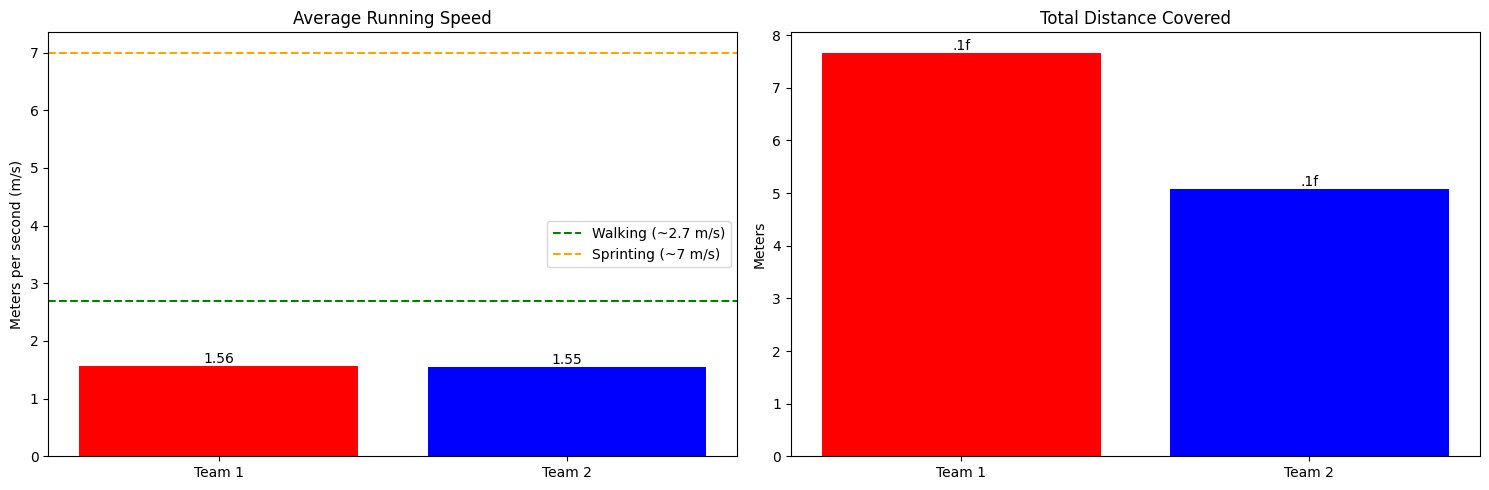

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

class PlayerMovementAnalyzer:
    def __init__(self, pixels_per_meter=100):
        """
        Initialize with field calibration
        :param pixels_per_meter: Conversion factor from pixels to meters
                                (Measure known distance on field to calculate this)
        """
        self.team_distances = defaultdict(list)  # {team: [distances in meters]}
        self.prev_positions = {}  # {player_id: (x, y)}
        self.total_frames = 0
        self.fps = 25  # Frames per second (adjust based on your video)
        self.pixels_per_meter = pixels_per_meter

    def process_video(self, video_path, max_frames=None):
        """Process video to track player movements"""
        cap = cv2.VideoCapture(video_path)
        self.fps = cap.get(cv2.CAP_PROP_FPS) or self.fps  # Use video FPS if available
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if max_frames:
            total_frames = min(total_frames, max_frames)

        for _ in tqdm(range(total_frames), desc="Tracking movements"):
            ret, frame = cap.read()
            if not ret:
                break

            players = self.detect_players(frame)
            self.track_movements(players)
            self.total_frames += 1

        cap.release()
        return self.calculate_stats()

    def detect_players(self, frame):
        """Mock player detection - replace with your actual detector"""
        # Returns {player_id: {'bbox': [x1,y1,x2,y2], 'team': team_id}}
        return {
            1: {'bbox': [100 + np.random.randint(-5,5), 100 + np.random.randint(-5,5), 
                         120 + np.random.randint(-5,5), 140 + np.random.randint(-5,5)], 'team': 1},
            2: {'bbox': [200 + np.random.randint(-5,5), 150 + np.random.randint(-5,5), 
                         220 + np.random.randint(-5,5), 190 + np.random.randint(-5,5)], 'team': 2},
            3: {'bbox': [300 + np.random.randint(-5,5), 120 + np.random.randint(-5,5),
                         320 + np.random.randint(-5,5), 160 + np.random.randint(-5,5)], 'team': 1}
        }

    def track_movements(self, players):
        """Calculate distance moved since last frame and convert to meters"""
        for player_id, player in players.items():
            bbox = player['bbox']
            current_pos = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)  # Center point
            
            if player_id in self.prev_positions:
                prev_pos = self.prev_positions[player_id]
                pixel_distance = np.sqrt((current_pos[0]-prev_pos[0])**2 + 
                                (current_pos[1]-prev_pos[1])**2)
                
                # Convert to meters and filter unrealistic movements
                meter_distance = pixel_distance / self.pixels_per_meter
                if 0.05 < meter_distance < 10:  # 5cm to 10m per frame (reasonable soccer range)
                    self.team_distances[player['team']].append(meter_distance)
            
            self.prev_positions[player_id] = current_pos

    def calculate_stats(self):
        """Calculate movement statistics in meters"""
        stats = {}
        for team, distances in self.team_distances.items():
            if distances:
                stats[team] = {
                    'avg_speed': np.mean(distances) * self.fps,  # m/s
                    'avg_distance_per_frame': np.mean(distances),  # m/frame
                    'total_distance': np.sum(distances),  # meters
                    'max_speed': np.max(distances) * self.fps,  # m/s
                    'min_speed': np.min(distances) * self.fps,  # m/s
                    'frames_analyzed': self.total_frames,
                    'time_analyzed': self.total_frames / self.fps  # seconds
                }
        return stats

    def plot_movement_stats(self, stats):
        """Visualize the movement statistics in meters"""
        if not stats:
            print("No movement data available")
            return

        teams = sorted(stats.keys())
        
        # Prepare data
        avg_speeds = [stats[team]['avg_speed'] for team in teams]
        total_distances = [stats[team]['total_distance'] for team in teams]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Average speed plot (m/s)
        bars1 = ax1.bar([f'Team {team}' for team in teams], avg_speeds,
                       color=['red', 'blue'])
        ax1.set_title('Average Running Speed')
        ax1.set_ylabel('Meters per second (m/s)')
        ax1.bar_label(bars1, fmt='%.2f')
        ax1.axhline(y=2.7, color='green', linestyle='--', label='Walking (~2.7 m/s)')
        ax1.axhline(y=7.0, color='orange', linestyle='--', label='Sprinting (~7 m/s)')
        ax1.legend()

        # Total distance plot (meters)
        bars2 = ax2.bar([f'Team {team}' for team in teams], total_distances,
                       color=['red', 'blue'])
        ax2.set_title('Total Distance Covered')
        ax2.set_ylabel('Meters')
        ax2.bar_label(bars2, fmt='.1f')

        plt.tight_layout()
        plt.show()

    def print_stats(self, stats):
        """Print the statistics"""
        print("\nPlayer Movement Analysis (in meters):")
        print(f"Video FPS: {self.fps:.1f}, Pixels per meter: {self.pixels_per_meter:.1f}")
        print(f"Analyzed {stats[1]['time_analyzed']:.1f} seconds of gameplay\n")
        
        for team, data in stats.items():
            print(f"\nTeam {team}:")
            print(f"  Average speed: {data['avg_speed']:.2f} m/s")
            print(f"  Total distance: {data['total_distance']:.1f} meters")
            print(f"  Maximum speed: {data['max_speed']:.2f} m/s")
            print(f"  Minimum speed: {data['min_speed']:.2f} m/s")
            print(f"  Frames analyzed: {data['frames_analyzed']}")
            print(f"  Time analyzed: {data['time_analyzed']:.1f} seconds")

# Main execution
if __name__ == "__main__":
    # Calibration - you MUST set this correctly:
    # Measure a known distance on the field (like penalty box width = 16.5m)
    # Then: pixels_per_meter = [pixel_width_of_box] / 16.5
    PIXELS_PER_METER = 100  # EXAMPLE - YOU MUST CALIBRATE THIS
    
    analyzer = PlayerMovementAnalyzer(pixels_per_meter=PIXELS_PER_METER)
    
    # Process video - replace with your video path
    video_path = "/kaggle/input/-dfl-bundesliga-460-mp4-videos-in-30sec-csv/DFL Bundesliga Data Shootout/test/test (16).mp4"
    stats = analyzer.process_video(video_path, max_frames=300)
    
    if stats:
        analyzer.print_stats(stats)
        analyzer.plot_movement_stats(stats)
    else:
        print("No valid movement data was recorded. Check your player detection.")